In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
df = pd.read_csv('../../data/raw_data/scenario_1.csv', keep_default_na = True,nrows=1850)
df.head()

,Time,pipeline_1,pipeline_2,pipeline_3,sep_lvl
0,0.000000,11.138935,11.085769,11.484986,0.476073
1,0.100000,11.138756,11.085440,11.484453,0.475311
2,0.233333,11.138499,11.085223,11.484049,0.474378
3,0.411111,11.138120,11.084999,11.483658,0.473195
4,0.648148,11.137534,11.084570,11.483118,0.471706


Посмотрим на входные данные:

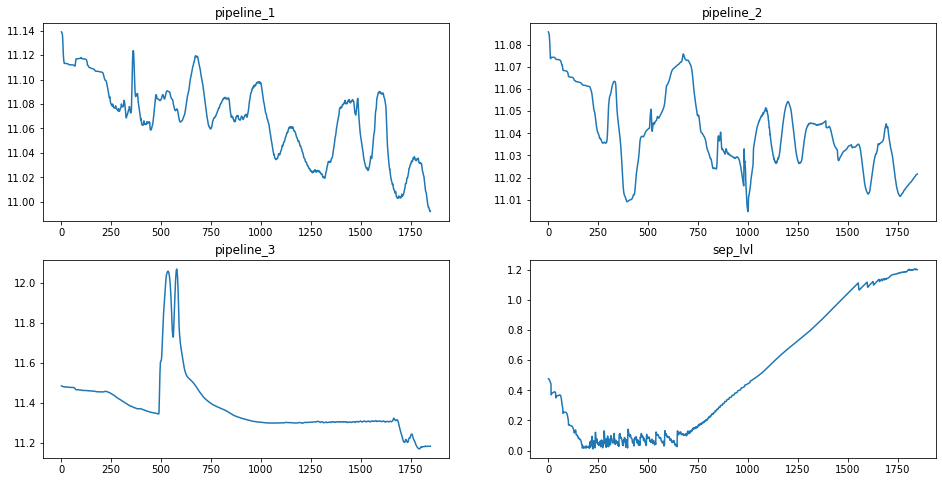

In [7]:
fig = plt.figure(figsize=(16, 8))

for i, col in enumerate( df.columns[1:] , 1):

    subplot = fig.add_subplot(2, 2, i)
    subplot.set_title('%s' % df.columns[i] )

    plt.plot(df[col]);

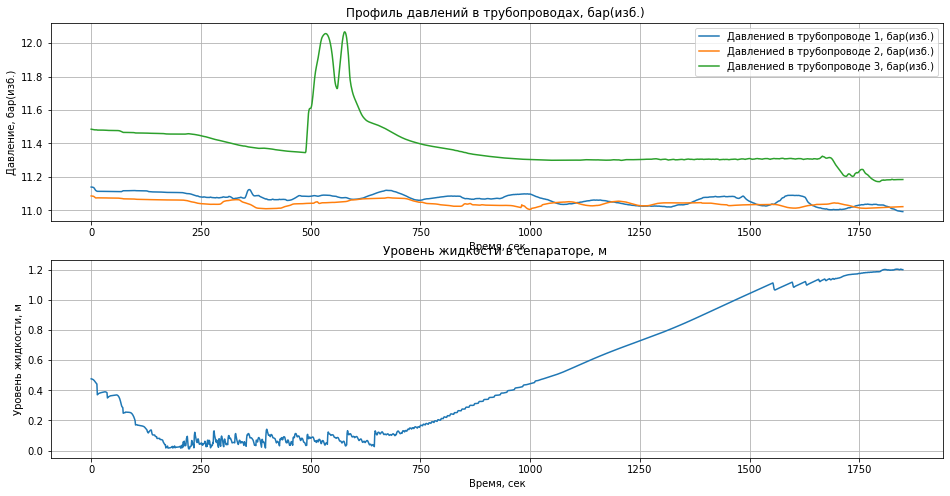

In [10]:
fig = plt.figure(figsize=(16, 8))

subplot = fig.add_subplot(2, 1, 1)

subplot.set_title('Профиль давлений в трубопроводах, бар(изб.) ')
plt.plot(df['pipeline_1'], label = 'Давлениеd в трубопроводе 1, бар(изб.)')
plt.plot(df['pipeline_2'], label = 'Давлениеd в трубопроводе 2, бар(изб.)')
plt.plot(df['pipeline_3'], label = 'Давлениеd в трубопроводе 3, бар(изб.)')

plt.legend(loc='best')

plt.ylabel('Давление, бар(изб.)')
plt.xlabel('Время, сек')
plt.grid();

subplot = fig.add_subplot(2, 1,2)

subplot.set_title('Уровень жидкости в сепараторе, м ')
plt.plot(df['sep_lvl'])

plt.ylabel('Уровень жидкости, м')
plt.xlabel('Время, сек')
plt.grid();


Слишком высокая нелинейность, добавим усреднение по скользящему окну. Или как его еще называют на фондовом рынке - N скользящая средняя.

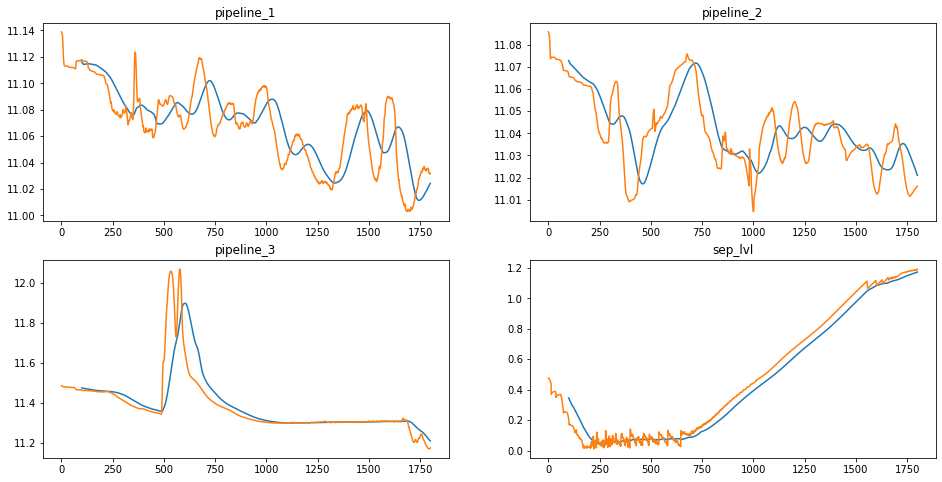

In [5]:
WINDOW_SIZE = 100

fig = plt.figure(figsize=(16, 8))

for i, col in enumerate( df.columns[1:] , 1):

    subplot = fig.add_subplot(2, 2, i)
    subplot.set_title('%s' % df.columns[i] )

    plt.plot(df[col].rolling(WINDOW_SIZE).mean())
    plt.plot(df[col]);

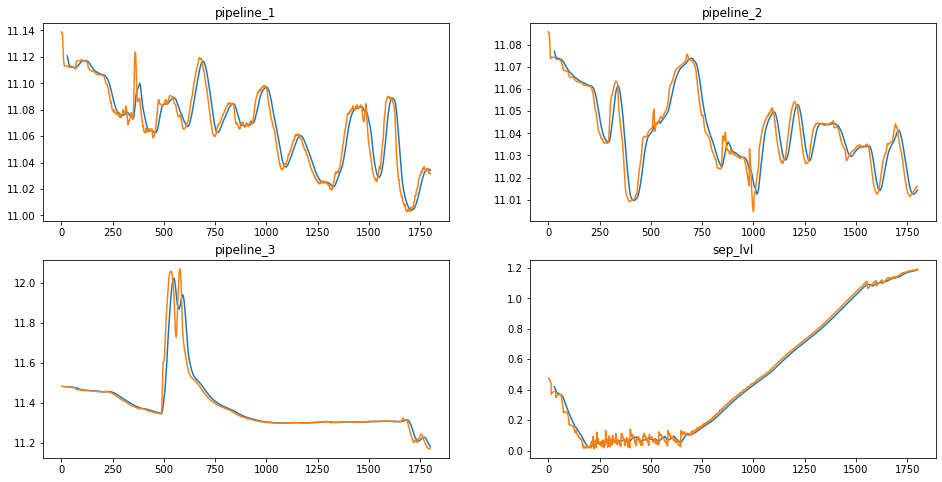

In [6]:
WINDOW_SIZE = 30

fig = plt.figure(figsize=(16, 8))

for i, col in enumerate( df.columns[1:] , 1):

    subplot = fig.add_subplot(2, 2, i)
    subplot.set_title('%s' % df.columns[i] )

    plt.plot(df[col].rolling(WINDOW_SIZE).mean())
    plt.plot(df[col]);

Для задачи нам необходимо Только сгладить sep_lvl ДО 600 секунды, так как до нее идет обыный режим работы, а после приходит пробка ( которую нужно "поймать")

Если мы оставим колебания ДО 600 сек., то наша мат. модель может сбоить( false triggering) на этом "шуме". 

Следовательно, оставляем скользящее окно на 100 шагов, Только для sep_lvl.

Волна жидксти "приходит" на 600 сек. посмотрим внимательнее когда именно она приходит и рост уровня жидкости будет нашим target или y для посследующих мат.моделей.

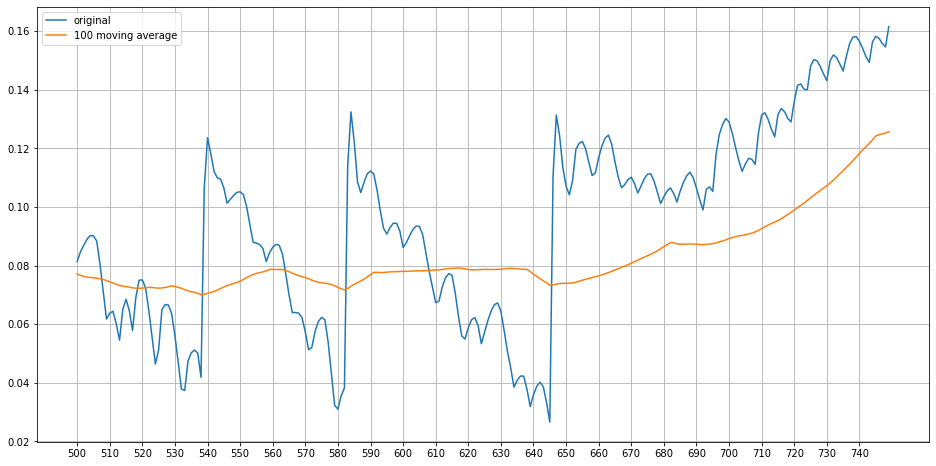

In [7]:
WINDOW_SIZE = 100
DIM = [500,750]
a = np.array(df.sep_lvl)

fig = plt.figure(figsize=(16, 8))
plt.plot(range(DIM[0],DIM[1]) , a[ DIM[0]:DIM[1] ], label = 'original')
b = np.array(df.sep_lvl.rolling(WINDOW_SIZE).mean())
plt.plot(range(DIM[0],DIM[1]) , b[ DIM[0]:DIM[1] ], label = f'{WINDOW_SIZE} moving average'  )
plt.grid()
plt.xticks( range(DIM[0],DIM[1],10 )   )
plt.legend(loc='best');

Мы видим, что примерно на 645 сек. Обычные колебания прекратились и начался рост. Стало быть наш lag  должен быть 645.

Применяем скользящее среднее только для sep_lvl, из остальных графиков (смотри графики выше) нас будет интересовать давление трубы "pipeline_3" так как на остальных трубах диапазон смены давления около 0, то есть будем считать давление на остальных трубах квази- стационарно. 

Так и должно быть. дело в том, что именнно в этом кейсе, приход пробки на сепаратор только от "pipeline_3". 

### Проверка на аномалии

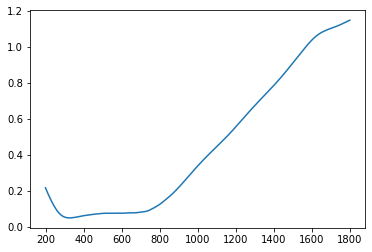

In [20]:
WINDOW_SIZE =100
df['sep_lvl'] = df.sep_lvl.rolling(WINDOW_SIZE).mean()
df.sep_lvl.dropna(inplace=True)
plt.plot(df.sep_lvl)

Нужно понять когда именно начался рост, для этого необходимо использовать детектор аномалий.
применим:
    
- mean detector - детоектор среднего значения
- ZDetector - детектор отклонения среднего значения в окне, по сравнению с общим накопленным средним 
- OneClassSVM - детектор построенный на Support Vector unsuprvised learning, - алогритм сам определяет когда началась аномалия.
    
Посмотрим сразу результаты:

In [13]:
from sklearn.svm import OneClassSVM

In [12]:
class detector:
    def __init__(self,threshold = 0.0113):
        self.threshold = threshold
        self.mean = 0
        self.count = 0 
        self.summa = 0
    
    def add_new_value(self,value):
        self.summa += value
        self.count +=1
        self.mean = self.summa / self.count
        
    def check_for_outlier(self, value):
        if abs(self.mean - value) > self.threshold:
            return True
        else: 
            return False
        
    

In [14]:
from collections import deque

In [15]:
class ZDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = 1e-8
        
    def add_new_value(self, value):
        x = value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = 1.*(g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = 1.*(w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check_for_outlier(self, value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

In [38]:
def plot_sep(value):
    DIM = [500,670]
    a = np.array(df.sep_lvl)

    fig = plt.figure(figsize=(12, 5))
    plt.plot(range(DIM[0],DIM[1]) , a[ DIM[0]:DIM[1] ], label = 'original')
    
    plt.plot(DIM , [value]*2, 'r--',label = 'detector')
    plt.grid()
    plt.xticks( range(DIM[0],DIM[1],10 )   )
    plt.xlabel('time')
    plt.ylabel('Separator liquid level')
    plt.legend(loc='best');

Mean Detector

269 0.07601185376550397


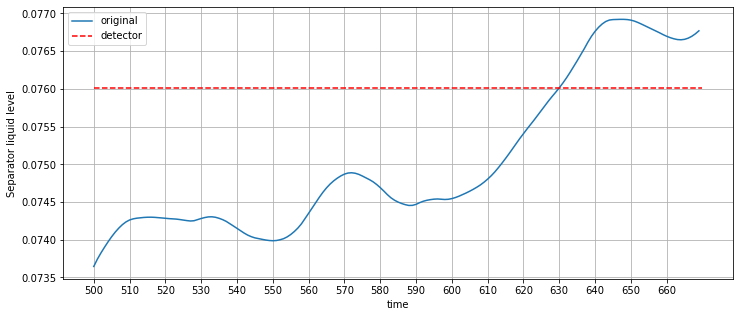

In [39]:
det = detector(threshold=.06)

for j,i in enumerate(df.sep_lvl[200:]):
    if np.isnan(i): continue
    det.add_new_value(i)
    #print(i, det.z_score)
    if det.check_for_outlier(i):
        print(j+200,i)
        plot_sep(i)
        break

Z Detector

C:\Users\Sony\AppData\Local\Temp/ipykernel_9648/3619728393.py:29: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = 1.*(g_std - w_std) / g_std
C:\Users\Sony\AppData\Local\Temp/ipykernel_9648/3619728393.py:32: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = 1.*(w_mean - g_mean) / SE


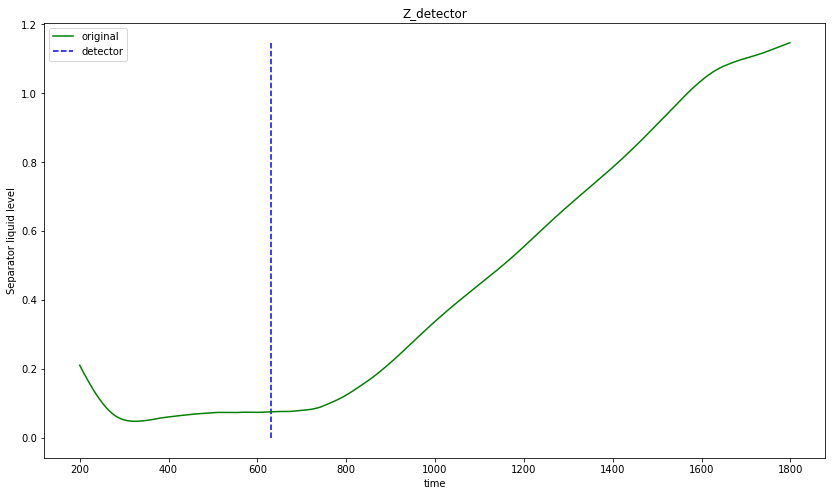

In [51]:
stop_points = []
det = ZDetector(window_size = 100, threshold=10)
for i, value in enumerate(df.sep_lvl[200:]):
    det.add_new_value(value)
    if det.check_for_outlier(value):
        stop_points.append(i)

plt.figure(figsize=(14,8))
plt.plot(df.sep_lvl[200:], 'g', label = 'original')
#plt.plot(df.sep_lvl[200:], 'b-', alpha=0.15)
plt.title('Z_detector')
plt.xlabel('time')
plt.ylabel('Separator liquid level')

if stop_points:
    plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(df.sep_lvl[200:]),
                  colors='b', linestyles='dashed',label = 'detector')

plt.legend(loc='best');

One Class SVM

In [52]:
from sklearn.svm import OneClassSVM

673


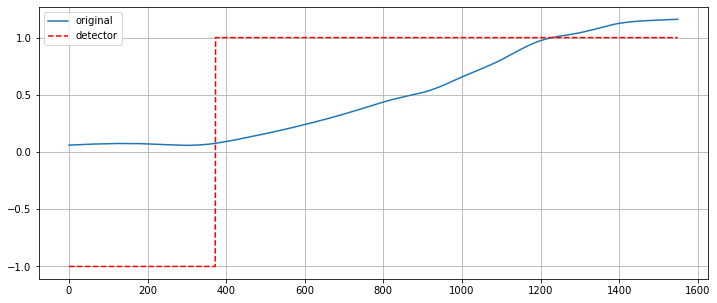

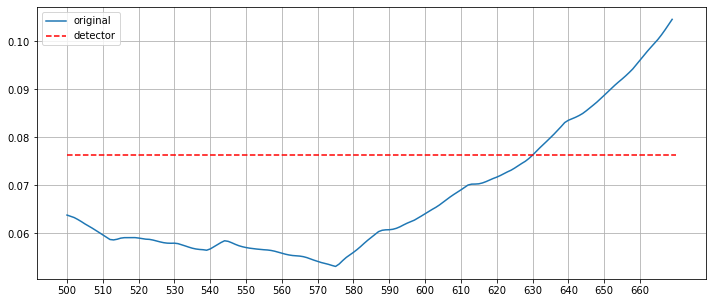

In [335]:
a = np.array(df.sep_lvl.rolling(100).mean())
oc_svm = OneClassSVM(nu=.24, kernel="sigmoid", gamma='scale')

oc_svm.fit(a[300:].reshape(-1,1))
pred = oc_svm.predict(a[300:].reshape(-1,1))

fig = plt.figure(figsize=(12, 5))
plt.plot(a[300:], label = 'original')

plt.plot(pred, 'r--',label = 'detector')
plt.grid()
plt.legend(loc='best');
print(np.argmax(pred)+300)
plot_sep(a[np.argmax(pred)+300]);